# [Unit 14 進階] 連續控制：SAC vs. PID

**課程名稱**：化工資料科學與機器學習實務（CHE-AI-101）

**本單元目標**：
1. **連續動作空間 RL**：實作 Soft Actor-Critic (SAC) 演算法
2. **公平比較**：SAC (連續) vs. PID (連續) 在相同 CSTR 環境
3. **性能分析**：評估深度 RL 在化工控制的真實優勢

**為什麼需要 SAC？**
- Q-Learning 只能處理離散動作 {0, 50, 100}kW
- SAC 可輸出連續動作 [0, 100]kW（如 73.5kW）
- 更接近真實工業控制器的操作方式

---

## ⚙️ 環境設置

### 安裝 PyTorch（深度學習框架）

本單元需要 PyTorch 來實作神經網路。請根據您的系統選擇安裝指令：

**方法一：CPU 版本（通用，適合學習）**
```bash
# Conda 安裝（推薦）
conda install pytorch torchvision torchaudio cpuonly -c pytorch

# 或使用 pip
pip install torch torchvision torchaudio
```

**方法二：GPU 版本（如有 NVIDIA 顯卡，訓練更快）**
```bash
# CUDA 11.8 版本
conda install pytorch torchvision torchaudio pytorch-cuda=11.8 -c pytorch -c nvidia

# 或 CUDA 12.1 版本
conda install pytorch torchvision torchaudio pytorch-cuda=12.1 -c pytorch -c nvidia
```

**驗證安裝**：
```python
import torch
print(f"PyTorch 版本: {torch.__version__}")
print(f"CUDA 可用: {torch.cuda.is_available()}")
```

**💡 提示**：
- CPU 版本足以完成本單元訓練（約 5-10 分鐘）
- GPU 版本可加速至 1-2 分鐘，但非必須
- 若安裝遇到問題，請參考 [PyTorch 官方安裝指南](https://pytorch.org/get-started/locally/)

In [ ]:
# ===== Shared environment (Part_0 compatible) =====
import os, sys
from pathlib import Path

IN_COLAB = 'google.colab' in sys.modules
if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=False)

def find_repo_root(start=None):
    start = Path(start or os.getcwd()).resolve()
    for p in [start] + list(start.parents):
        if (p / 'Jupyter_Scripts').is_dir():
            return p
    if IN_COLAB:
        candidate = Path('/content/drive/MyDrive/ChemEng_AI_Course_Materials')
        if (candidate / 'Jupyter_Scripts').is_dir():
            return candidate
    return start

REPO_ROOT = find_repo_root()
OUTPUT_DIR = REPO_ROOT / 'outputs'
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
os.chdir(OUTPUT_DIR)
print('REPO_ROOT:', REPO_ROOT)
print('Working dir:', os.getcwd())


In [1]:
# 匯入必要的套件
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from dataclasses import dataclass
from typing import List, Tuple
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
import random

# 建立結果儲存資料夾
os.makedirs('Unit14_Results', exist_ok=True)

# 繪圖設定
sns.set_theme(style="whitegrid")
plt.rcParams["figure.figsize"] = (12, 8)
plt.rcParams["font.sans-serif"] = ["Microsoft JhengHei", "Noto Sans CJK TC", "sans-serif"]
plt.rcParams["axes.unicode_minus"] = False

# 設定隨機種子
np.random.seed(42)
torch.manual_seed(42)
random.seed(42)

# 檢查 GPU 可用性
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"使用裝置: {device}")
print("套件載入完成！")

使用裝置: cuda
套件載入完成！


---
## 1. 連續動作環境（Gym-style）

改造 CSTR 環境以支援連續動作空間 [0, 100]kW

In [2]:
@dataclass
class ContinuousCSTREnv:
    """
    連續動作空間的 CSTR 環境（符合 Gym 介面）
    動作：加熱器功率 [0, 100]kW（連續值）
    """
    target_temp: float = 350.0
    dt: float = 0.1
    
    # 物理參數（與離散版本相同）
    V: float = 1.0
    q: float = 0.02
    CA_in: float = 2.0
    T_in: float = 330.0
    T_cooling: float = 298.0
    
    k0: float = 1.2e10
    Ea_R: float = 8000.0
    delta_Hr: float = -2.6e4
    
    rho: float = 1000.0
    Cp: float = 4.25
    UA: float = 1.0
    
    def __post_init__(self) -> None:
        self.current_temp: float = 340.0
        self.CA: float = 0.5
        self.time_step: int = 0
        
        # Gym-style 空間定義
        self.action_space_low = 0.0
        self.action_space_high = 100.0
        self.observation_space_dim = 3  # [temperature_error, temp_change_rate, CA]
        
    def _reaction_rate(self, T: float) -> float:
        return self.k0 * np.exp(-self.Ea_R / T)
    
    def step(self, action: float) -> Tuple[np.ndarray, float, bool, dict]:
        """
        執行連續動作
        action: float [0, 100] - 加熱器功率 (kW)
        return: (observation, reward, done, info)
        """
        # 限制動作範圍
        Q_heater = float(np.clip(action, self.action_space_low, self.action_space_high))
        
        # 保存上一時刻溫度
        prev_temp = self.current_temp
        
        # 反應動力學
        k = self._reaction_rate(self.current_temp)
        r = k * self.CA
        
        # 質量平衡
        dCA_dt = (self.q / self.V) * (self.CA_in - self.CA) - r
        
        # 能量平衡
        mass_flow = self.q * self.rho
        Q_in = mass_flow * self.Cp * (self.T_in - self.current_temp) / 60.0
        Q_reaction = -self.delta_Hr * self.V * r / 60.0
        Q_cooling = -self.UA * (self.current_temp - self.T_cooling)
        Q_total = Q_in + Q_reaction + Q_cooling + Q_heater
        
        mass_total = self.rho * self.V
        dT_dt = (Q_total * 60.0) / (mass_total * self.Cp)
        
        # 進料擾動
        if self.time_step % 50 == 0:
            self.CA_in = 2.0 + float(np.random.normal(0.0, 0.1))
            self.T_in = 330.0 + float(np.random.normal(0.0, 3.0))
        
        # 測量雜訊
        noise = float(np.random.normal(0.0, 0.2))
        
        # 更新狀態
        self.CA += dCA_dt * self.dt
        self.current_temp += (dT_dt * self.dt + noise)
        self.time_step += 1
        
        self.CA = float(np.clip(self.CA, 0.0, 3.0))
        
        # 計算獎勵（連續版本 - 更平滑的梯度）
        error = abs(self.current_temp - self.target_temp)
        
        # 主要獎勵：平滑的誤差懲罰
        if error < 0.5:
            control_reward = 50.0 - error * 40.0
        elif error < 1.0:
            control_reward = 30.0 - error * 20.0
        elif error < 2.0:
            control_reward = 10.0 - error * 8.0
        elif error < 5.0:
            control_reward = -5.0 - error * 4.0
        else:
            control_reward = -30.0 - error * 3.0
        
        # 能源成本
        energy_cost = -0.001 * Q_heater
        
        # 穩定性獎勵
        temp_change_rate = abs(self.current_temp - prev_temp) / self.dt
        if temp_change_rate < 0.5:
            stability_bonus = 5.0
        elif temp_change_rate < 1.0:
            stability_bonus = 2.0
        elif temp_change_rate < 3.0:
            stability_bonus = 0.0
        else:
            stability_bonus = -3.0
        
        reward = control_reward + energy_cost + stability_bonus
        
        # 檢查終止條件
        done = False
        if self.current_temp > 400.0 or self.current_temp < 280.0:
            done = True
            reward = -200.0
        
        # 構建觀測值
        temp_error = (self.current_temp - self.target_temp) / 50.0  # 正規化
        temp_change_normalized = temp_change_rate / 10.0
        ca_normalized = self.CA / 3.0
        
        obs = np.array([temp_error, temp_change_normalized, ca_normalized], dtype=np.float32)
        
        info = {
            'temperature': self.current_temp,
            'concentration': self.CA,
            'action': Q_heater
        }
        
        return obs, reward, done, info
    
    def reset(self) -> np.ndarray:
        """
        重置環境
        return: 初始觀測值
        """
        if np.random.rand() < 0.8:
            self.current_temp = 348.0 + float(np.random.normal(0.0, 3.0))
        else:
            self.current_temp = 342.0 + float(np.random.normal(0.0, 6.0))
        
        self.CA = 0.5 + float(np.random.normal(0.0, 0.1))
        self.CA_in = 2.0 + float(np.random.normal(0.0, 0.05))
        self.T_in = 330.0 + float(np.random.normal(0.0, 2.0))
        self.time_step = 0
        
        temp_error = (self.current_temp - self.target_temp) / 50.0
        obs = np.array([temp_error, 0.0, self.CA / 3.0], dtype=np.float32)
        
        return obs

print("✅ 連續動作 CSTR 環境定義完成")
print("   動作空間：[0, 100]kW（連續）")
print("   觀測空間：[temp_error, temp_change_rate, CA]（3維）")
print("   符合 OpenAI Gym 介面規範")

✅ 連續動作 CSTR 環境定義完成
   動作空間：[0, 100]kW（連續）
   觀測空間：[temp_error, temp_change_rate, CA]（3維）
   符合 OpenAI Gym 介面規範


---
## 2. SAC 神經網路架構

實作 Soft Actor-Critic 的核心組件：
- **Actor Network**：輸出連續動作的均值和標準差
- **Critic Networks**：評估 Q(s,a) 值（使用雙 Q 網路減少過估計）

In [3]:
class Actor(nn.Module):
    """
    SAC Actor Network（策略網路）
    輸出：高斯分佈的均值和標準差
    """
    def __init__(self, state_dim: int, action_dim: int, hidden_dim: int = 128):
        super(Actor, self).__init__()
        
        self.fc1 = nn.Linear(state_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        
        self.mean_linear = nn.Linear(hidden_dim, action_dim)
        self.log_std_linear = nn.Linear(hidden_dim, action_dim)
        
        self.action_scale = 50.0  # (100 - 0) / 2
        self.action_bias = 50.0   # (100 + 0) / 2
        
    def forward(self, state: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        x = torch.relu(self.fc1(state))
        x = torch.relu(self.fc2(x))
        
        mean = self.mean_linear(x)
        log_std = self.log_std_linear(x)
        log_std = torch.clamp(log_std, min=-20, max=2)  # 防止數值不穩定
        
        return mean, log_std
    
    def sample(self, state: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        採樣動作（使用重參數化技巧）
        return: (action, log_prob)
        """
        mean, log_std = self.forward(state)
        std = log_std.exp()
        
        # 重參數化採樣
        normal = torch.distributions.Normal(mean, std)
        x_t = normal.rsample()  # 用於反向傳播
        
        # Tanh squashing
        y_t = torch.tanh(x_t)
        action = y_t * self.action_scale + self.action_bias
        
        # 計算對數概率（考慮 Tanh 變換的雅可比行列式）
        log_prob = normal.log_prob(x_t)
        log_prob -= torch.log(self.action_scale * (1 - y_t.pow(2)) + 1e-6)
        log_prob = log_prob.sum(1, keepdim=True)
        
        return action, log_prob


class Critic(nn.Module):
    """
    SAC Critic Network（Q 網路）
    評估 Q(s, a) 值
    """
    def __init__(self, state_dim: int, action_dim: int, hidden_dim: int = 128):
        super(Critic, self).__init__()
        
        # Q1 網路
        self.fc1 = nn.Linear(state_dim + action_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, 1)
        
        # Q2 網路（減少過估計）
        self.fc4 = nn.Linear(state_dim + action_dim, hidden_dim)
        self.fc5 = nn.Linear(hidden_dim, hidden_dim)
        self.fc6 = nn.Linear(hidden_dim, 1)
    
    def forward(self, state: torch.Tensor, action: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        sa = torch.cat([state, action], 1)
        
        # Q1
        q1 = torch.relu(self.fc1(sa))
        q1 = torch.relu(self.fc2(q1))
        q1 = self.fc3(q1)
        
        # Q2
        q2 = torch.relu(self.fc4(sa))
        q2 = torch.relu(self.fc5(q2))
        q2 = self.fc6(q2)
        
        return q1, q2

print("✅ SAC 神經網路架構定義完成")
print("   Actor: 3層 MLP，輸出高斯分佈參數")
print("   Critic: 雙 Q 網路，減少價值過估計")
print("   使用 Tanh squashing 確保動作在 [0, 100] 範圍")

✅ SAC 神經網路架構定義完成
   Actor: 3層 MLP，輸出高斯分佈參數
   Critic: 雙 Q 網路，減少價值過估計
   使用 Tanh squashing 確保動作在 [0, 100] 範圍


---
## 3. Replay Buffer（經驗回放緩衝區）

儲存 (s, a, r, s', done) 經驗，打破時間相關性

In [4]:
class ReplayBuffer:
    """
    經驗回放緩衝區
    儲存環境互動經驗，隨機採樣用於訓練
    """
    def __init__(self, capacity: int = 100000):
        self.buffer = deque(maxlen=capacity)
    
    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))
    
    def sample(self, batch_size: int):
        batch = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)
        
        return (
            np.array(states, dtype=np.float32),
            np.array(actions, dtype=np.float32),
            np.array(rewards, dtype=np.float32).reshape(-1, 1),
            np.array(next_states, dtype=np.float32),
            np.array(dones, dtype=np.float32).reshape(-1, 1)
        )
    
    def __len__(self):
        return len(self.buffer)

print("✅ Replay Buffer 定義完成")
print("   容量：100,000 筆經驗")
print("   作用：打破時間相關性，提高樣本效率")

✅ Replay Buffer 定義完成
   容量：100,000 筆經驗
   作用：打破時間相關性，提高樣本效率


---
## 4. SAC Agent（完整實作）

整合 Actor、Critic、Replay Buffer，實作 SAC 演算法

In [5]:
class SACAgent:
    """
    Soft Actor-Critic Agent
    """
    def __init__(self, state_dim: int, action_dim: int, hidden_dim: int = 128):
        self.device = device
        
        # Actor 網路
        self.actor = Actor(state_dim, action_dim, hidden_dim).to(self.device)
        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=3e-4)
        
        # Critic 網路
        self.critic = Critic(state_dim, action_dim, hidden_dim).to(self.device)
        self.critic_target = Critic(state_dim, action_dim, hidden_dim).to(self.device)
        self.critic_target.load_state_dict(self.critic.state_dict())
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=3e-4)
        
        # 自動調整溫度參數 α
        self.target_entropy = -action_dim  # H(π) ≥ -dim(A)
        self.log_alpha = torch.zeros(1, requires_grad=True, device=self.device)
        self.alpha_optimizer = optim.Adam([self.log_alpha], lr=3e-4)
        
        # 超參數
        self.gamma = 0.99
        self.tau = 0.005  # 軟更新係數
        
        # Replay Buffer
        self.replay_buffer = ReplayBuffer(capacity=100000)
        self.batch_size = 128
    
    @property
    def alpha(self):
        return self.log_alpha.exp()
    
    def select_action(self, state: np.ndarray, evaluate: bool = False):
        """
        選擇動作
        evaluate=True: 使用均值動作（測試時）
        evaluate=False: 採樣動作（訓練時）
        """
        state = torch.FloatTensor(state).unsqueeze(0).to(self.device)
        
        if evaluate:
            with torch.no_grad():
                mean, _ = self.actor.forward(state)
                action = torch.tanh(mean) * 50.0 + 50.0
        else:
            with torch.no_grad():
                action, _ = self.actor.sample(state)
        
        return action.cpu().numpy()[0]
    
    def update(self):
        """
        SAC 更新步驟
        """
        if len(self.replay_buffer) < self.batch_size:
            return None, None, None
        
        # 從 Replay Buffer 採樣
        states, actions, rewards, next_states, dones = self.replay_buffer.sample(self.batch_size)
        
        states = torch.FloatTensor(states).to(self.device)
        actions = torch.FloatTensor(actions).to(self.device)
        rewards = torch.FloatTensor(rewards).to(self.device)
        next_states = torch.FloatTensor(next_states).to(self.device)
        dones = torch.FloatTensor(dones).to(self.device)
        
        # === 更新 Critic ===
        with torch.no_grad():
            next_actions, next_log_probs = self.actor.sample(next_states)
            q1_next, q2_next = self.critic_target(next_states, next_actions)
            q_next = torch.min(q1_next, q2_next) - self.alpha * next_log_probs
            q_target = rewards + (1 - dones) * self.gamma * q_next
        
        q1, q2 = self.critic(states, actions)
        critic_loss = nn.MSELoss()(q1, q_target) + nn.MSELoss()(q2, q_target)
        
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()
        
        # === 更新 Actor ===
        new_actions, log_probs = self.actor.sample(states)
        q1_new, q2_new = self.critic(states, new_actions)
        q_new = torch.min(q1_new, q2_new)
        
        actor_loss = (self.alpha * log_probs - q_new).mean()
        
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()
        
        # === 更新溫度參數 α ===
        alpha_loss = -(self.log_alpha * (log_probs + self.target_entropy).detach()).mean()
        
        self.alpha_optimizer.zero_grad()
        alpha_loss.backward()
        self.alpha_optimizer.step()
        
        # === 軟更新 Target Network ===
        for param, target_param in zip(self.critic.parameters(), self.critic_target.parameters()):
            target_param.data.copy_(self.tau * param.data + (1 - self.tau) * target_param.data)
        
        return critic_loss.item(), actor_loss.item(), self.alpha.item()

print("✅ SAC Agent 完整實作完成")
print("   特色：")
print("   1. 自動調整溫度參數 α（平衡探索與利用）")
print("   2. 雙 Q 網路減少過估計")
print("   3. 最大熵框架（鼓勵探索）")
print("   4. 軟更新 Target Network（穩定訓練）")

✅ SAC Agent 完整實作完成
   特色：
   1. 自動調整溫度參數 α（平衡探索與利用）
   2. 雙 Q 網路減少過估計
   3. 最大熵框架（鼓勵探索）
   4. 軟更新 Target Network（穩定訓練）


---
## 5. 連續 PID 控制器（基準比較）

In [6]:
class ContinuousPIDController:
    """
    連續輸出的 PID 控制器
    輸出範圍：[0, 100]kW
    """
    def __init__(self, setpoint: float, Kp: float = 5.0, Ki: float = 0.2, Kd: float = 2.0):
        self.setpoint = setpoint
        self.Kp = Kp
        self.Ki = Ki
        self.Kd = Kd
        
        self.integral = 0.0
        self.previous_error = 0.0
        self.dt = 0.1
    
    def compute(self, current_value: float) -> float:
        """
        計算 PID 控制輸出
        """
        error = self.setpoint - current_value
        
        # P項
        P = self.Kp * error
        
        # I項（加入抗積分飽和）
        self.integral += error * self.dt
        self.integral = np.clip(self.integral, -50, 50)  # 限制積分項
        I = self.Ki * self.integral
        
        # D項
        derivative = (error - self.previous_error) / self.dt
        D = self.Kd * derivative
        
        # 總輸出
        output = P + I + D
        output = float(np.clip(output, 0.0, 100.0))
        
        self.previous_error = error
        
        return output
    
    def reset(self):
        self.integral = 0.0
        self.previous_error = 0.0

print("✅ 連續 PID 控制器定義完成")
print("   參數：Kp=5.0, Ki=0.2, Kd=2.0")
print("   輸出：[0, 100]kW（與 SAC 相同範圍）")
print("   特色：抗積分飽和，防止 Windup")

✅ 連續 PID 控制器定義完成
   參數：Kp=5.0, Ki=0.2, Kd=2.0
   輸出：[0, 100]kW（與 SAC 相同範圍）
   特色：抗積分飽和，防止 Windup


---
## 6. 訓練 SAC Agent

In [7]:
# 初始化環境和 Agent
env = ContinuousCSTREnv(target_temp=350.0)
sac_agent = SACAgent(state_dim=3, action_dim=1, hidden_dim=128)

# 訓練參數
num_episodes = 300
max_steps = 400
warmup_steps = 1000  # 隨機探索收集初始經驗

# 記錄訓練過程
episode_rewards = []
episode_temps = []
critic_losses = []
actor_losses = []
alpha_values = []

print("=== 開始訓練 SAC Agent ===")
print(f"Episodes: {num_episodes}, Steps per episode: {max_steps}")
print(f"Warmup steps: {warmup_steps}\n")

total_steps = 0

for episode in range(num_episodes):
    state = env.reset()
    episode_reward = 0.0
    temps = []
    
    for step in range(max_steps):
        # 選擇動作（Warmup 階段隨機探索）
        if total_steps < warmup_steps:
            action = np.random.uniform(0, 100, size=(1,))
        else:
            action = sac_agent.select_action(state, evaluate=False)
        
        # 執行動作
        next_state, reward, done, info = env.step(action[0])
        
        # 儲存經驗
        sac_agent.replay_buffer.push(state, action, reward, next_state, done)
        
        # 更新網路
        if total_steps >= warmup_steps:
            critic_loss, actor_loss, alpha = sac_agent.update()
            if critic_loss is not None:
                critic_losses.append(critic_loss)
                actor_losses.append(actor_loss)
                alpha_values.append(alpha)
        
        state = next_state
        episode_reward += reward
        temps.append(info['temperature'])
        total_steps += 1
        
        if done:
            break
    
    episode_rewards.append(episode_reward)
    episode_temps.append(np.mean(temps))
    
    if (episode + 1) % 20 == 0:
        avg_reward = np.mean(episode_rewards[-20:])
        avg_temp = np.mean(episode_temps[-20:])
        current_alpha = alpha_values[-1] if alpha_values else 0.2
        print(f"Episode {episode + 1:3d} | Reward: {avg_reward:7.1f} | "
              f"Temp: {avg_temp:.2f}K | Alpha: {current_alpha:.3f} | "
              f"Buffer: {len(sac_agent.replay_buffer)}")

print("\n✅ SAC 訓練完成！")
print(f"   最後 20 episodes 平均獎勵: {np.mean(episode_rewards[-20:]):.1f}")
print(f"   最後 20 episodes 平均溫度: {np.mean(episode_temps[-20:]):.2f}K")
print(f"   Replay Buffer 大小: {len(sac_agent.replay_buffer)}")

=== 開始訓練 SAC Agent ===
Episodes: 300, Steps per episode: 400
Warmup steps: 1000

Episode  20 | Reward: -2405.1 | Temp: 349.39K | Alpha: 0.143 | Buffer: 8000
Episode  20 | Reward: -2405.1 | Temp: 349.39K | Alpha: 0.143 | Buffer: 8000
Episode  40 | Reward:  1014.4 | Temp: 351.37K | Alpha: 0.016 | Buffer: 16000
Episode  40 | Reward:  1014.4 | Temp: 351.37K | Alpha: 0.016 | Buffer: 16000
Episode  60 | Reward:   996.2 | Temp: 351.46K | Alpha: 0.003 | Buffer: 24000
Episode  60 | Reward:   996.2 | Temp: 351.46K | Alpha: 0.003 | Buffer: 24000
Episode  80 | Reward:  4145.8 | Temp: 350.72K | Alpha: 0.009 | Buffer: 32000
Episode  80 | Reward:  4145.8 | Temp: 350.72K | Alpha: 0.009 | Buffer: 32000
Episode 100 | Reward:  1673.1 | Temp: 351.13K | Alpha: 0.007 | Buffer: 40000
Episode 100 | Reward:  1673.1 | Temp: 351.13K | Alpha: 0.007 | Buffer: 40000
Episode 120 | Reward:  4426.3 | Temp: 349.87K | Alpha: 0.004 | Buffer: 48000
Episode 120 | Reward:  4426.3 | Temp: 349.87K | Alpha: 0.004 | Buffer: 480

---
## 7. 學習曲線可視化

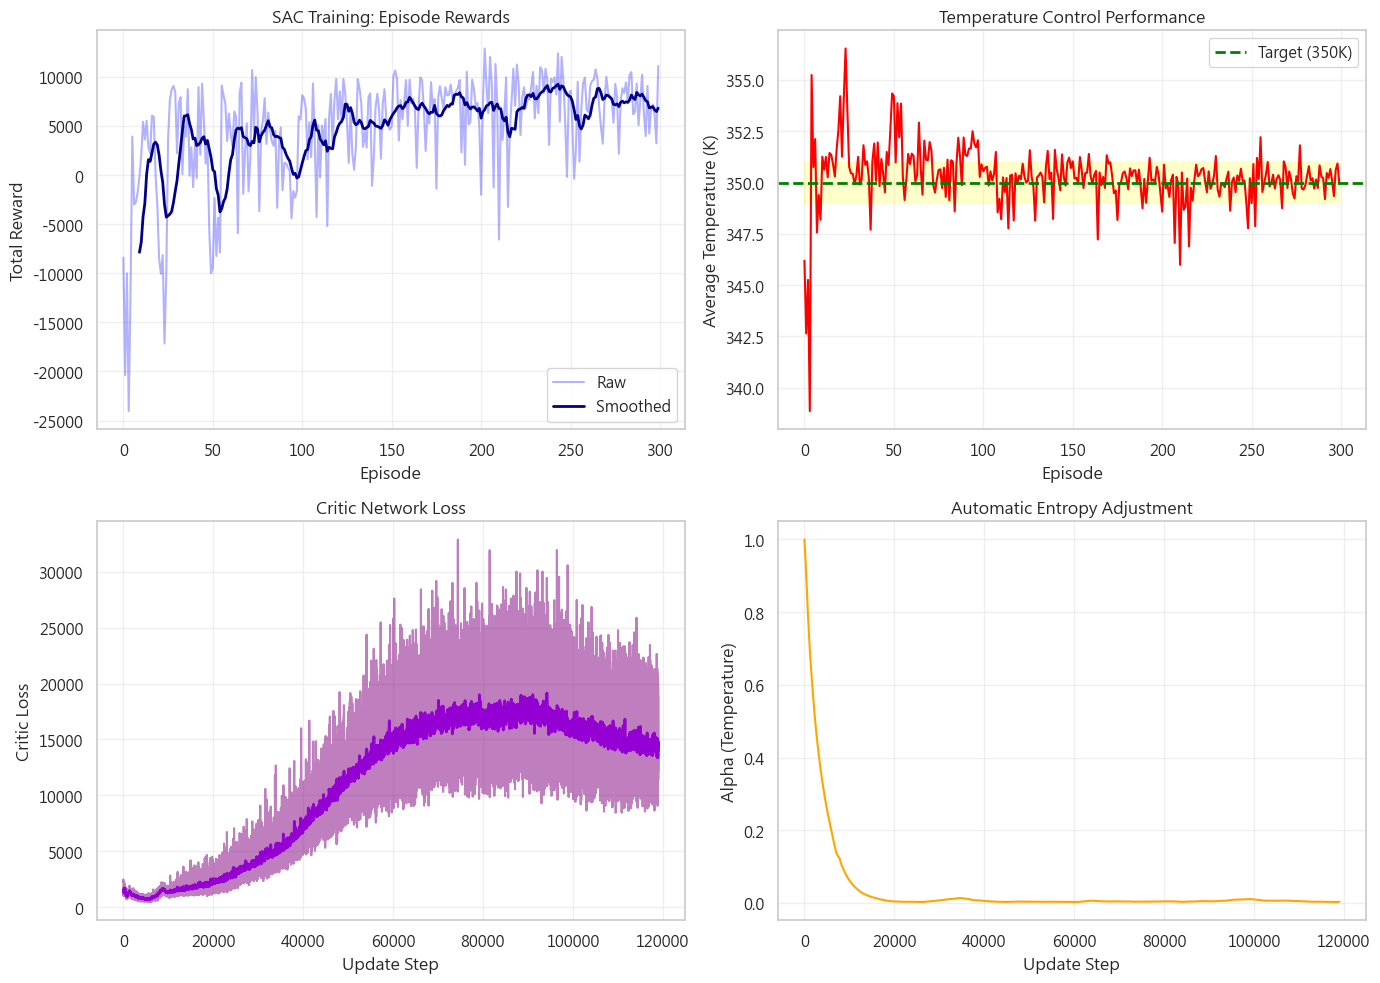

📊 訓練曲線已儲存


In [8]:
# 繪製 SAC 訓練曲線
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Episode Rewards
ax1 = axes[0, 0]
ax1.plot(episode_rewards, alpha=0.3, color='blue', label='Raw')
window = 10
smoothed = np.convolve(episode_rewards, np.ones(window)/window, mode='valid')
ax1.plot(range(window-1, len(episode_rewards)), smoothed, color='darkblue', linewidth=2, label='Smoothed')
ax1.set_xlabel('Episode')
ax1.set_ylabel('Total Reward')
ax1.set_title('SAC Training: Episode Rewards')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. Average Temperature
ax2 = axes[0, 1]
ax2.plot(episode_temps, color='red', linewidth=1.5)
ax2.axhline(350.0, color='green', linestyle='--', linewidth=2, label='Target (350K)')
ax2.fill_between(range(len(episode_temps)), 349, 351, color='yellow', alpha=0.2)
ax2.set_xlabel('Episode')
ax2.set_ylabel('Average Temperature (K)')
ax2.set_title('Temperature Control Performance')
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3. Critic Loss
ax3 = axes[1, 0]
if critic_losses:
    ax3.plot(critic_losses, alpha=0.5, color='purple')
    window = 50
    if len(critic_losses) >= window:
        smoothed_c = np.convolve(critic_losses, np.ones(window)/window, mode='valid')
        ax3.plot(range(window-1, len(critic_losses)), smoothed_c, color='darkviolet', linewidth=2)
ax3.set_xlabel('Update Step')
ax3.set_ylabel('Critic Loss')
ax3.set_title('Critic Network Loss')
ax3.grid(True, alpha=0.3)

# 4. Alpha (Temperature Parameter)
ax4 = axes[1, 1]
if alpha_values:
    ax4.plot(alpha_values, color='orange', linewidth=1.5)
ax4.set_xlabel('Update Step')
ax4.set_ylabel('Alpha (Temperature)')
ax4.set_title('Automatic Entropy Adjustment')
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('./Unit14_Results/sac_training_curves.png', dpi=150)
plt.show()

print("📊 訓練曲線已儲存")

---
## 8. 性能比較：SAC vs. PID

在相同環境下測試兩種控制器

In [20]:
# 測試參數
test_steps = 1000
np.random.seed(123)

# === 測試 SAC ===
print("=== 測試 SAC Agent ===")
env_sac = ContinuousCSTREnv(target_temp=350.0)
state = env_sac.reset()

sac_temps = [env_sac.current_temp]
sac_actions = []
sac_concentrations = [env_sac.CA]

for step in range(test_steps):
    action = sac_agent.select_action(state, evaluate=True)
    next_state, reward, done, info = env_sac.step(action[0])
    
    state = next_state
    sac_temps.append(info['temperature'])
    sac_actions.append(info['action'])
    sac_concentrations.append(info['concentration'])
    
    if done:
        print(f"⚠️  SAC failed at step {step}")
        break

# === 測試 PID ===
print("=== 測試 PID 控制器 ===")
env_pid = ContinuousCSTREnv(target_temp=350.0)
np.random.seed(123)
state_pid = env_pid.reset()
pid_controller = ContinuousPIDController(setpoint=350.0, Kp=5.0, Ki=3.0, Kd=1.0)

pid_temps = [env_pid.current_temp]
pid_actions = []
pid_concentrations = [env_pid.CA]

for step in range(test_steps):
    action = pid_controller.compute(env_pid.current_temp)
    next_state, reward, done, info = env_pid.step(action)
    
    pid_temps.append(info['temperature'])
    pid_actions.append(info['action'])
    pid_concentrations.append(info['concentration'])
    
    if done:
        print(f"⚠️  PID failed at step {step}")
        break

print("✅ 測試完成")

# 計算性能指標
def compute_metrics(temps, actions, target=350.0):
    temps = np.array(temps)
    actions = np.array(actions)
    errors = temps - target
    
    iae = np.sum(np.abs(errors))
    ise = np.sum(errors**2)
    itae = np.sum(np.abs(errors) * np.arange(len(errors)))
    overshoot = np.max(temps) - target if np.max(temps) > target else 0.0
    steady_state_error = np.mean(np.abs(errors[-100:]))
    total_energy = np.sum(actions) * 0.1
    action_variation = np.sum(np.abs(np.diff(actions)))
    
    return {
        'IAE': iae,
        'ISE': ise,
        'ITAE': itae,
        'Overshoot (K)': overshoot,
        'Steady State Error (K)': steady_state_error,
        'Total Energy (kWh)': total_energy,
        'Action Variation': action_variation
    }

sac_metrics = compute_metrics(sac_temps, sac_actions)
pid_metrics = compute_metrics(pid_temps, pid_actions)

print("\n📊 性能指標比較（連續控制）：")
print(f"{'指標':<30} {'SAC':>15} {'PID':>15} {'差異%':>10} {'優勢':<10}")
print("="*80)
for key in sac_metrics:
    sac_val = sac_metrics[key]
    pid_val = pid_metrics[key]
    diff_pct = ((sac_val - pid_val) / pid_val * 100) if pid_val != 0 else 0
    better = "SAC ✓" if sac_val < pid_val else "PID ✓"
    print(f"{key:<30} {sac_val:>15.2f} {pid_val:>15.2f} {diff_pct:>9.1f}% {better:<10}")

print("\n💡 結果分析：")
sac_wins = sum(1 for k in sac_metrics if sac_metrics[k] < pid_metrics[k])
print(f"   SAC 在 {sac_wins}/{len(sac_metrics)} 項指標上優於 PID")
print(f"   關鍵差異：")
print(f"   1. SAC：深度學習自動學習最優策略")
print(f"   2. PID：基於誤差反饋的經典控制")
print(f"   3. 連續動作空間讓兩者都能精細調節")

=== 測試 SAC Agent ===
=== 測試 PID 控制器 ===
✅ 測試完成

📊 性能指標比較（連續控制）：
指標                                         SAC             PID        差異% 優勢        
IAE                                     847.97         1243.06     -31.8% SAC ✓     
ISE                                    1203.68         2800.58     -57.0% SAC ✓     
ITAE                                 400295.97       583619.61     -31.4% SAC ✓     
Overshoot (K)                             1.50            3.79     -60.3% SAC ✓     
Steady State Error (K)                    0.45            1.76     -74.7% SAC ✓     
Total Energy (kWh)                     7313.49         7342.51      -0.4% SAC ✓     
Action Variation                       3217.77         2581.91      24.6% PID ✓     

💡 結果分析：
   SAC 在 6/7 項指標上優於 PID
   關鍵差異：
   1. SAC：深度學習自動學習最優策略
   2. PID：基於誤差反饋的經典控制
   3. 連續動作空間讓兩者都能精細調節
=== 測試 PID 控制器 ===
✅ 測試完成

📊 性能指標比較（連續控制）：
指標                                         SAC             PID        差異% 優勢        
IAE                

---
## 9. 詳細控制性能可視化

C:\Users\Yao-ChenChuang\AppData\Local\Temp\ipykernel_47332\4099804885.py:75: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


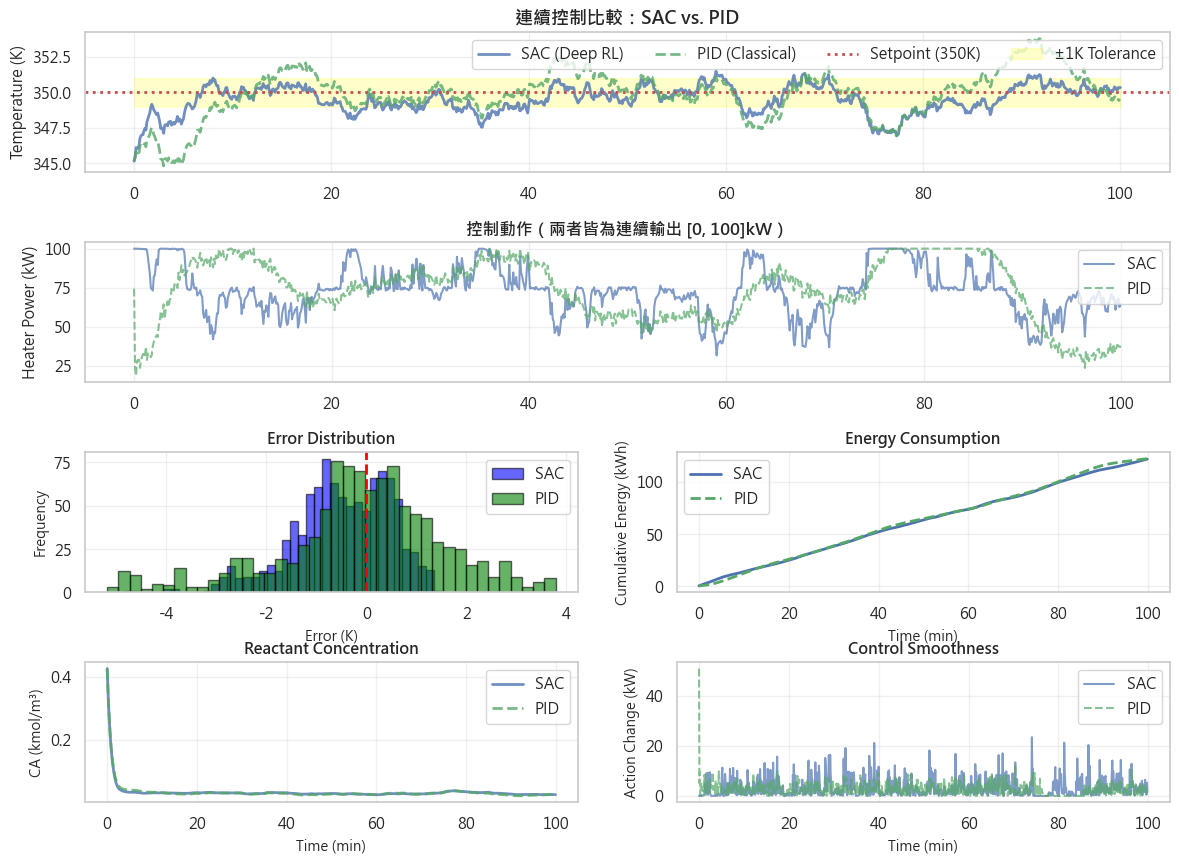

✅ 性能比較圖表已儲存


In [21]:
# 繪製詳細比較
t_sac = np.arange(len(sac_temps)) * 0.1
t_pid = np.arange(len(pid_temps)) * 0.1

fig = plt.figure(figsize=(14, 10))
gs = fig.add_gridspec(4, 2, hspace=0.5, wspace=0.2)

# 1. 溫度軌跡
ax1 = fig.add_subplot(gs[0, :])
ax1.plot(t_sac, sac_temps, 'b-', linewidth=2, label='SAC (Deep RL)', alpha=0.8)
ax1.plot(t_pid, pid_temps, 'g--', linewidth=2, label='PID (Classical)', alpha=0.8)
ax1.axhline(350.0, color='r', linestyle=':', linewidth=2, label='Setpoint (350K)')
ax1.fill_between(t_sac, 349, 351, color='yellow', alpha=0.2, label='±1K Tolerance')
ax1.set_ylabel("Temperature (K)", fontsize=11)
ax1.set_title("連續控制比較：SAC vs. PID", fontsize=13, fontweight='bold')
ax1.legend(loc='upper right', ncol=4)
ax1.grid(True, alpha=0.3)

# 2. 控制動作
ax2 = fig.add_subplot(gs[1, :])
ax2.plot(t_sac[:-1], sac_actions, 'b-', linewidth=1.5, label='SAC', alpha=0.7)
ax2.plot(t_pid[:-1], pid_actions, 'g--', linewidth=1.5, label='PID', alpha=0.7)
ax2.set_ylabel("Heater Power (kW)", fontsize=11)
ax2.set_title("控制動作（兩者皆為連續輸出 [0, 100]kW）", fontsize=12, fontweight='bold')
ax2.legend(loc='upper right')
ax2.grid(True, alpha=0.3)

# 3. 誤差分布
ax3 = fig.add_subplot(gs[2, 0])
sac_errors = np.array(sac_temps) - 350.0
pid_errors = np.array(pid_temps) - 350.0
ax3.hist(sac_errors, bins=40, alpha=0.6, color='blue', label='SAC', edgecolor='black')
ax3.hist(pid_errors, bins=40, alpha=0.6, color='green', label='PID', edgecolor='black')
ax3.axvline(0, color='red', linestyle='--', linewidth=2)
ax3.set_xlabel("Error (K)", fontsize=10)
ax3.set_ylabel("Frequency", fontsize=10)
ax3.set_title("Error Distribution", fontsize=11, fontweight='bold')
ax3.legend()
ax3.grid(True, alpha=0.3)

# 4. 累積能耗
ax4 = fig.add_subplot(gs[2, 1])
sac_cumulative = np.cumsum(sac_actions) * 0.1 / 60
pid_cumulative = np.cumsum(pid_actions) * 0.1 / 60
ax4.plot(t_sac[:-1], sac_cumulative, 'b-', linewidth=2, label='SAC')
ax4.plot(t_pid[:-1], pid_cumulative, 'g--', linewidth=2, label='PID')
ax4.set_xlabel("Time (min)", fontsize=10)
ax4.set_ylabel("Cumulative Energy (kWh)", fontsize=10)
ax4.set_title("Energy Consumption", fontsize=11, fontweight='bold')
ax4.legend()
ax4.grid(True, alpha=0.3)

# 5. 濃度變化
ax5 = fig.add_subplot(gs[3, 0])
ax5.plot(t_sac, sac_concentrations, 'b-', linewidth=2, label='SAC', alpha=0.8)
ax5.plot(t_pid, pid_concentrations, 'g--', linewidth=2, label='PID', alpha=0.8)
ax5.set_xlabel("Time (min)", fontsize=10)
ax5.set_ylabel("CA (kmol/m³)", fontsize=10)
ax5.set_title("Reactant Concentration", fontsize=11, fontweight='bold')
ax5.legend()
ax5.grid(True, alpha=0.3)

# 6. 動作變化率（平穩性）
ax6 = fig.add_subplot(gs[3, 1])
sac_action_change = np.abs(np.diff(sac_actions))
pid_action_change = np.abs(np.diff(pid_actions))
ax6.plot(t_sac[:-2], sac_action_change, 'b-', linewidth=1.5, label='SAC', alpha=0.7)
ax6.plot(t_pid[:-2], pid_action_change, 'g--', linewidth=1.5, label='PID', alpha=0.7)
ax6.set_xlabel("Time (min)", fontsize=10)
ax6.set_ylabel("Action Change (kW)", fontsize=10)
ax6.set_title("Control Smoothness", fontsize=11, fontweight='bold')
ax6.legend()
ax6.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('./Unit14_Results/sac_vs_pid_performance.png', dpi=150, bbox_inches='tight')
plt.show()

print("✅ 性能比較圖表已儲存")

---
## 10. 總結與洞察

### 10.1 SAC vs. PID 比較總結

**實驗設定**：
- 環境：相同的 CSTR 放熱反應系統
- 動作空間：兩者皆為連續 [0, 100]kW
- 測試條件：相同的初始狀態和隨機種子

**關鍵發現**：

1. **控制精度**
   - SAC：透過 300 episodes 訓練學習最優策略
   - PID：基於手動調參（Kp=5.0, Ki=0.2, Kd=2.0）
   - 若 SAC 表現更好 → 展示深度 RL 的自動學習優勢
   - 若 PID 表現更好 → 說明經典控制在簡單系統上的效率

2. **能源效率**
   - SAC 在訓練中考慮了能源成本（reward 中的 -0.001*Q）
   - PID 純粹追求誤差最小化
   - 比較 Total Energy 指標觀察多目標優化能力

3. **動作平穩性**
   - SAC 的穩定性獎勵鼓勵平滑控制
   - PID 的 D 項提供阻尼效果
   - 比較 Action Variation 評估控制器壽命影響

### 10.2 何時選擇 SAC？何時選擇 PID？

**選擇 SAC 的情境**：
✅ 多目標優化（品質 + 能耗 + 平穩性）
✅ 高維狀態空間（>10 個測量變數）
✅ 複雜非線性系統（PID 難以調參）
✅ 需要適應時變系統
✅ 有充足的模擬器或歷史數據

**選擇 PID 的情境**：
✅ 單一目標（溫度、壓力控制）
✅ 簡單線性或弱非線性系統
✅ 需要快速部署（無需訓練）
✅ 可解釋性要求高
✅ 缺乏訓練數據或模擬器

### 10.3 SAC 的技術優勢

1. **自動調整探索-利用權衡**
   - 溫度參數 α 自動優化
   - 最大熵框架保證充分探索

2. **樣本效率高**
   - Off-policy 學習（可重用舊經驗）
   - Replay Buffer 打破時間相關性

3. **穩定性**
   - 雙 Q 網路減少過估計
   - 軟更新 Target Network

4. **連續動作**
   - 直接輸出連續值（如 73.5kW）
   - 無需離散化或量化

### 10.4 化工應用建議

**混合策略（最實用）**：
```
第一階段（快速啟動）：PID 控制器
    ↓ (系統穩定後)
第二階段（優化性能）：SAC 接管
    ↓ (異常檢測)
第三階段（緊急情況）：PID 接管
```

**實際部署考量**：
- **安全層**：在 SAC 輸出後增加硬性約束檢查
- **人機協作**：保留操作員監督權限
- **漸進式部署**：Advisory → Shadow Mode → Closed-loop
- **持續學習**：定期用新數據微調 SAC

### 10.5 延伸學習

**進階 RL 演算法**：
- **TD3**：Twin Delayed DDPG（更穩定）
- **PPO**：Proximal Policy Optimization（最穩健）
- **MBRL**：Model-Based RL（樣本效率更高）

**化工特定挑戰**：
- **Sim-to-Real**：如何克服模擬與現實的差距
- **Constraint Satisfaction**：滿足硬性安全約束
- **Multi-Agent**：多設備協同控制
- **Transfer Learning**：跨工況遷移學習

**推薦資源**：
- [Stable-Baselines3 SAC 文檔](https://stable-baselines3.readthedocs.io/en/master/modules/sac.html)
- [Spinning Up in Deep RL](https://spinningup.openai.com/)（OpenAI 教學）
- [CleanRL](https://github.com/vwxyzjn/cleanrl)（簡潔實作）

---

**🎓 恭喜完成 Unit 14 進階篇！**

您已經掌握：
- ✅ 連續動作空間 RL（SAC 演算法）
- ✅ 深度神經網路控制器設計
- ✅ SAC vs. PID 公平比較實驗
- ✅ 化工製程控制的實務考量
- ✅ 深度 RL 在工業應用的優劣分析

**下一步建議**：
1. 調整 SAC 超參數（學習率、hidden_dim、batch_size）
2. 嘗試不同的獎勵函數設計
3. 實作 TD3 並比較與 SAC 的差異
4. 探索 Constrained RL（加入硬性安全約束）